In [1]:
import sys

import rics

# Print relevant versions
print(f"{rics.__version__=}")
print(f"{sys.version=}")

rics.__version__='5.0.1.dev1'
sys.version='3.11.12 (main, Apr  9 2025, 08:55:55) [GCC 13.3.0]'


In [2]:
from itertools import product

import numpy as np
import pandas as pd

rng = np.random.default_rng(1999)
alnum = [*"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"]
strings = ["".join(rng.choice(alnum, 16)) for _ in range(1024)]
del alnum, rng


def make_sample_data(len: int, num_groups: int, dtype: str) -> pd.DataFrame:
    rng = np.random.default_rng(len * num_groups)
    group = pd.Series(rng.choice(strings, len), dtype=dtype)

    return pd.DataFrame(
        {
            "Loss": rng.uniform(-500, 500, len).round(1),
            "Group": group,
            # Add random columns to move around to make copying more expensive.
            # Should probably have a lot more than 4 "baggage" columns.
            "random floats": rng.random(len),
            "random integers": rng.integers(100, size=len),
            "random booleans": rng.integers(2, size=len, dtype=bool),
            "random strings": rng.choice(strings, len),
        }
    )


labels = {}
case_args = []
for case_arg in product(
    [
        1000,
        10_000,
        1_000_000,
        5_000_000,
        25_000_000,
    ],
    [10, 1000, 2500],
    ["str", "string[pyarrow]", "category"],
):
    case_args.append(case_arg)

case_arg = case_args[-1]
print(f"{case_arg=}")
make_sample_data(*case_arg).sample(3)

case_arg=(25000000, 2500, 'category')


,Loss,Group,random floats,random integers,random booleans,random strings
889290,206.5,We6ntAQUupGVyr98,0.888924,44,False,ho8acPbKkYvI4zHg
12795497,197.8,1k28rTub4B8OyLJF,0.270312,86,True,87GgURTRFy7E7mey
13451161,-429.6,aiZpdmI5wfssJOHO,0.477953,20,True,NfLcYbJdSWeRIhXu


In [3]:
import logging

from rics import configure_stuff

configure_stuff(rics_level="INFO")

👻 Configured some stuff just the way I like it!


# Pandas GroupBy row selection
Selecting the best row per group. Best is defined as `min(df["Loss"])`.

## Load data
Load some representative data we need for testing (that doesn't change between test cases or candidates).

## Define candidates
Select lowest `Loss` per `Group`.

In [4]:
def linear_search(df: pd.DataFrame) -> pd.DataFrame:
    best = {}
    for idx, row in df.iterrows():
        group = row["Group"]
        loss = row["Loss"]

        group_best = best.get(group)

        if group_best is None:
            best[group] = loss, idx
        else:
            best_loss = group_best[0]
            if loss < best_loss:
                best[group] = loss, idx

    ids = [group_best[1] for group_best in best.values()]
    return df.loc[ids]


def sort_groupby_head(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values("Loss", inplace=True)  # inplace is ~2x faster
    return df.groupby("Group", observed=True).head(1)


def groupby_idxmin_loc(df: pd.DataFrame) -> pd.DataFrame:
    ids = df.groupby("Group", observed=True)["Loss"].idxmin()
    return df.loc[ids]


def groupby_idxmin_loc_astype_cat(df: pd.DataFrame) -> pd.DataFrame:
    df["Group"] = df["Group"].astype("category")
    ids = df.groupby("Group", observed=True)["Loss"].idxmin()
    return df.loc[ids]


candidates = {
    "Linear search": linear_search,
    "Sort-GroupBy-Head": sort_groupby_head,
    "GroupBy-IdxMin-loc": groupby_idxmin_loc,
    # "GroupBy-IdxMin-loc (astype=category)": groupby_idxmin_loc_astype_cat,
}

## Verification
Make sure candidates are equivalent.

In [5]:
from tqdm.auto import tqdm

objs = [
    cand(make_sample_data(*case_args[0])).sort_values("Group") for cand in tqdm(candidates.values(), desc="generate")
]
objs[0]["Group"] = objs[0]["Group"].astype(str)

for obj in tqdm(objs, desc="validate"):
    obj["Group"] = obj["Group"].astype(str)
    pd.testing.assert_frame_equal(objs[0], obj)
pd.concat(objs, names=["Candidate"], keys=candidates).droplevel(None)

generate:   0%|          | 0/3 [00:00<?, ?it/s]

validate:   0%|          | 0/3 [00:00<?, ?it/s]

,Loss,Group,random floats,random integers,random booleans,random strings
Candidate,,,,,,
Linear search,396.6,048oqgrNQuHcMHB8,0.513284,93,True,MDdgsB1syvi3fE6s
Linear search,-359.4,05CfNhEklTnY8s2M,0.0342078,49,True,lQTt44Kzw5IyYg58
Linear search,-162.9,0Dw9hbisYOaEqtOs,0.352322,52,True,hcIJo4vlPekkAT4z
Linear search,-475.7,0F0AJUJB7rhhAnZE,0.455902,86,True,Yz0eWVOJykpL82OQ
Linear search,-2.6,0PCyz0FNLULUFs1Y,0.307939,37,True,BWnkSBxrw4x8XaB5
...,...,...,...,...,...,...
GroupBy-IdxMin-loc,-230.3,zKPaQTqJi4VVU4oJ,0.608556,25,False,GJALG337mBrUTyXt
GroupBy-IdxMin-loc,-380,zTuB1jNPbMnj3iJs,0.0205174,53,True,RI9Cn7DUPe7qAWC5
GroupBy-IdxMin-loc,-295.5,zY4vNnzv2D6sQATI,0.926889,86,True,Mi7M5tmBblO8EtWy


In [6]:
del objs

## Run performance comparison
The `case_args` will be used as run result keys.

In [7]:
from rics.performance import (
    MultiCaseTimer,
    SkipIfParams,
    get_best,
    plot_run,
    to_dataframe,
)

In [8]:
timer = MultiCaseTimer(
    candidates,
    make_sample_data,
    case_args=case_args,
)

In [9]:
def skip_if(params: SkipIfParams) -> bool:
    return params.candidate is linear_search and len(params.data) > 1_000_000

In [10]:
run_results = timer.run(number=2, progress=True, skip_if=skip_if)

  0%|          | 0/135 [00:00<?, ?it/s]

2025-05-29T18:54:02.568 [rics.performance:INFO] Evaluate candidate 'Linear search' 5x2 times per datum..
2025-05-29T19:17:42.861 [rics.performance:INFO] Evaluate candidate 'Sort-GroupBy-Head' 5x2 times per datum..
2025-05-29T19:27:35.846 [rics.performance:INFO] Evaluate candidate 'GroupBy-IdxMin-loc' 5x2 times per datum..


In [11]:
names = timer.derive_names()
df = to_dataframe(run_results, names=names)

## Plot results
Using facets for data size and type.

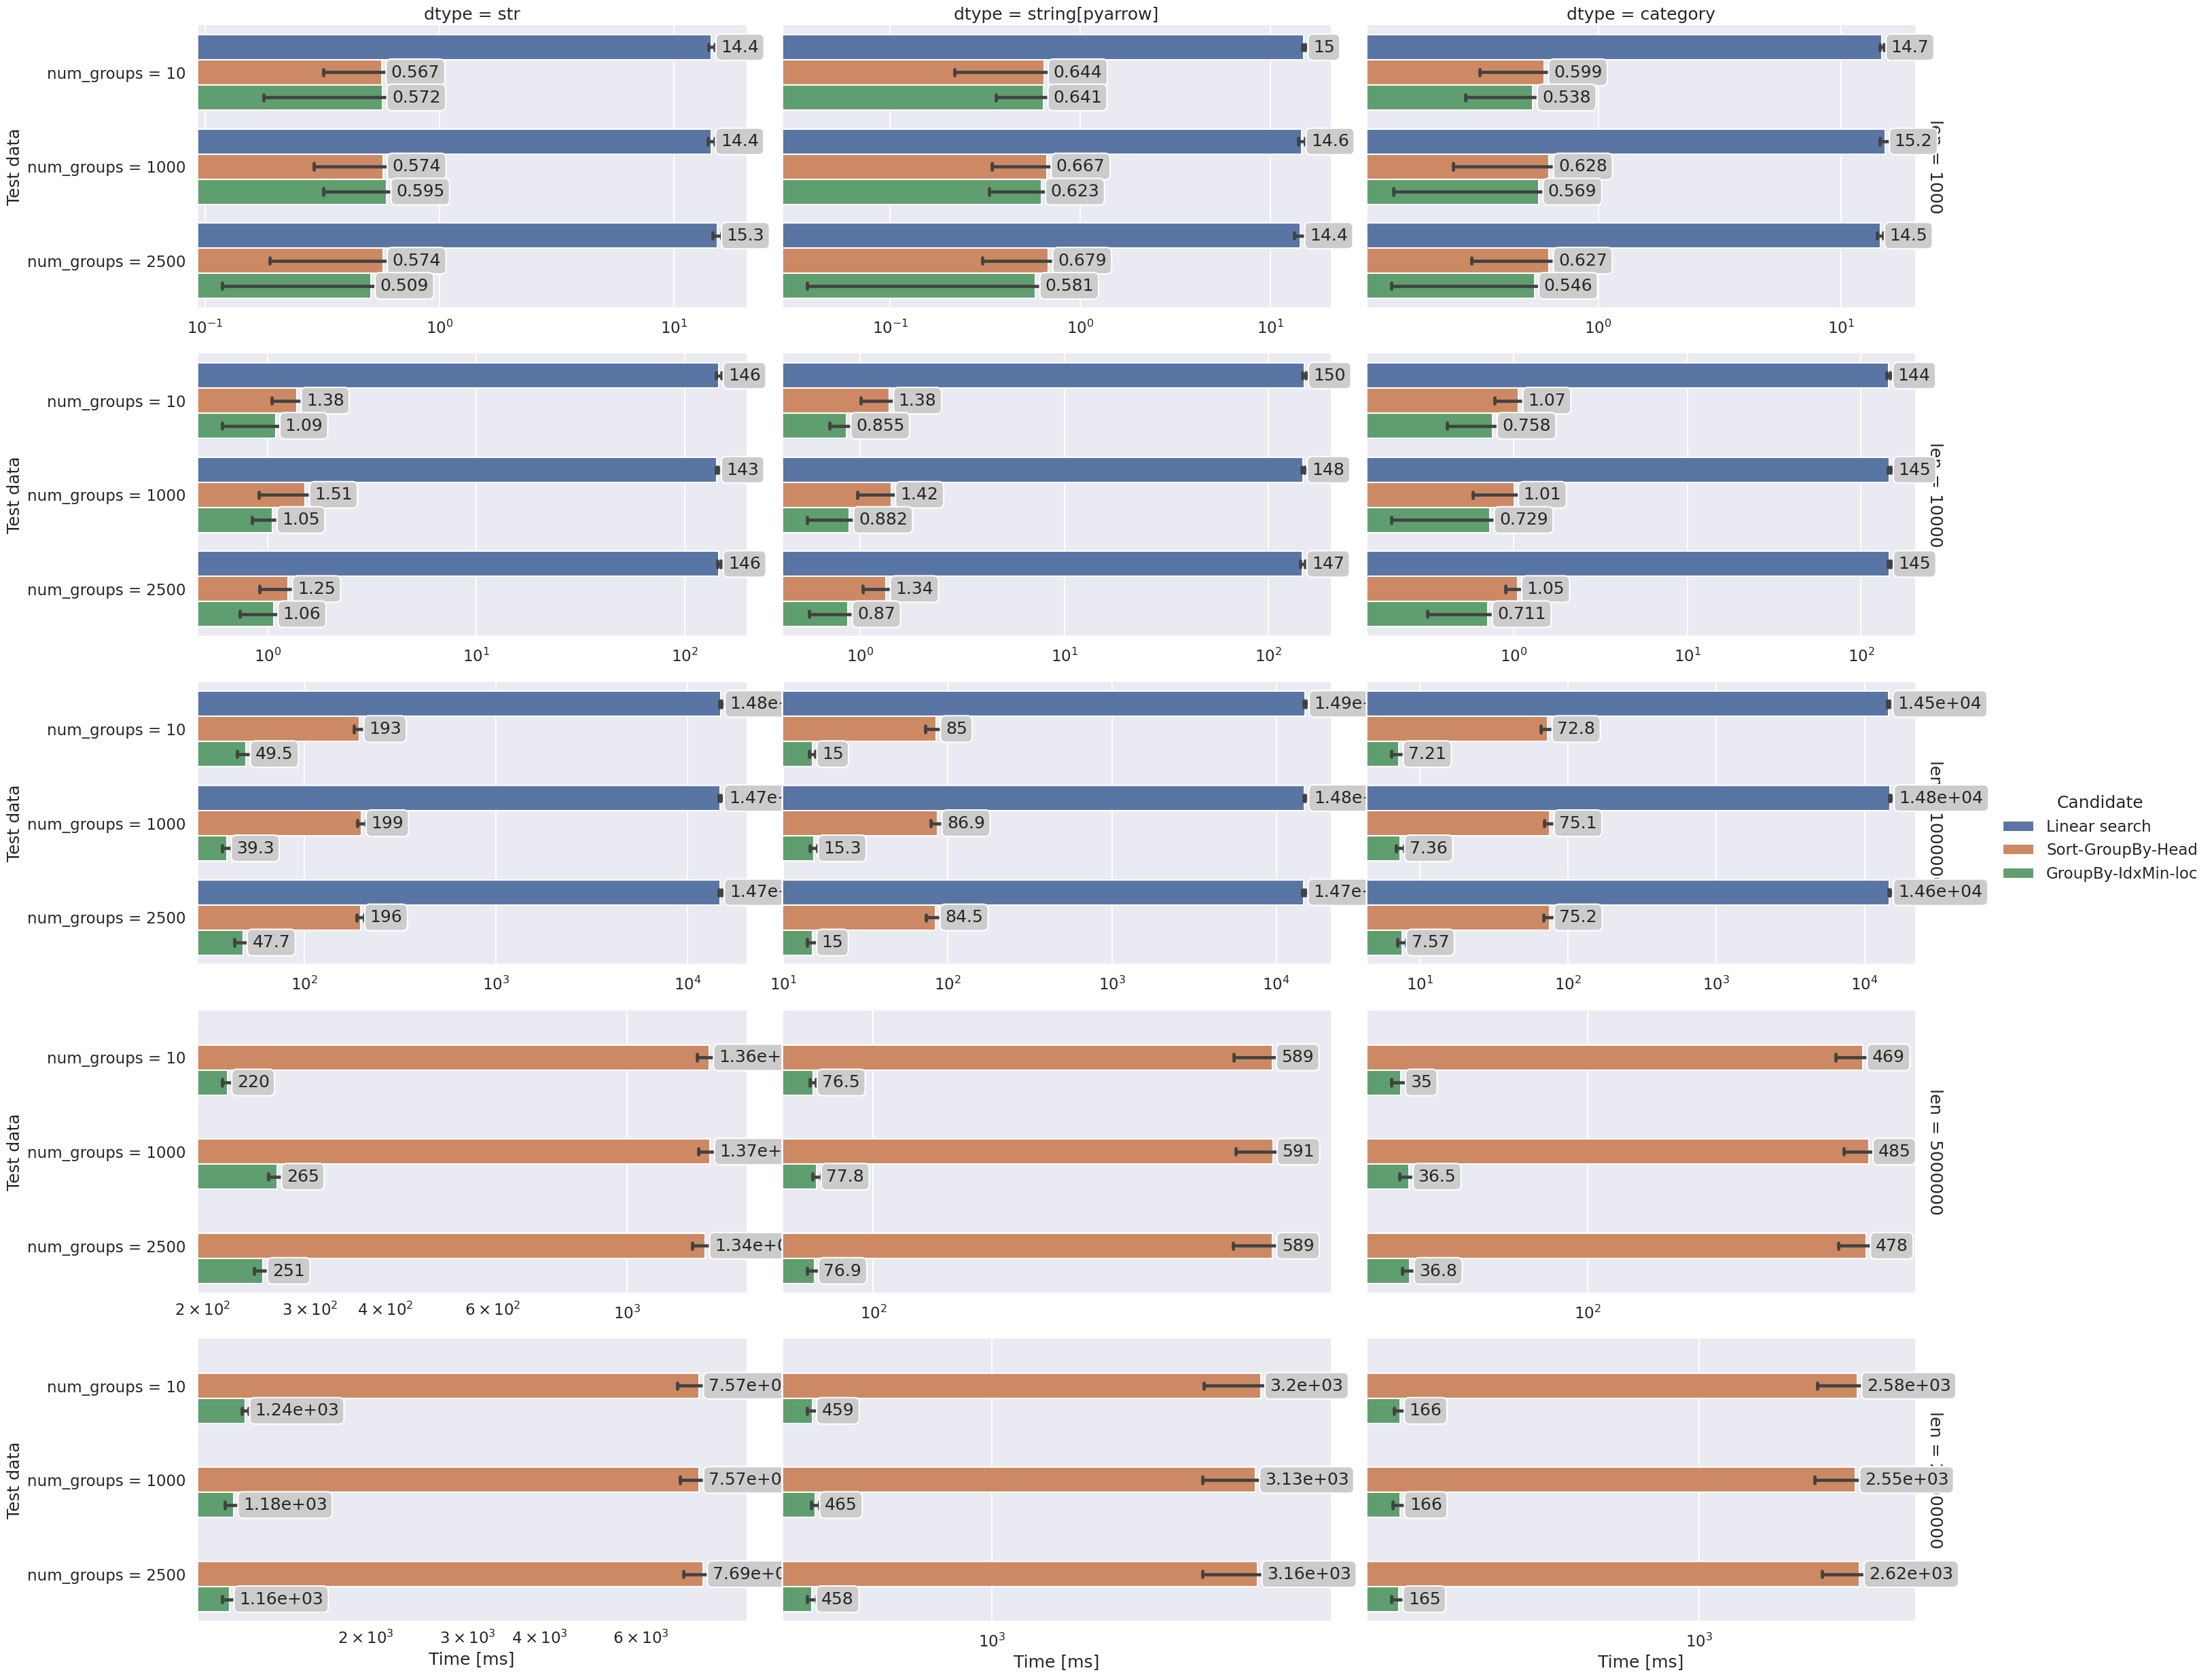

In [12]:
facet_grid = plot_run(
    df,
    names=names,
    row="len",
    col="dtype",
    sharex=False,
    log_scale=True,
    margin_titles=True,
    horizontal=True,
)

### Performance summary
Best choice per data label.

In [13]:
best = get_best(df)
best

,Candidate,Run no,Time [s],Test data,len,num_groups,dtype,Time [ms],Time [μs],Time [ns],Times min,Times mean
392,GroupBy-IdxMin-loc,2,0.000509343,"(1000, 2500, str)",1000,2500,str,0.509343,509.343,509343,1,0.0881793
373,GroupBy-IdxMin-loc,3,0.000538251,"(1000, 10, category)",1000,10,category,0.538251,538.251,538251,1,0.0975648
404,GroupBy-IdxMin-loc,4,0.000545796,"(1000, 2500, category)",1000,2500,category,0.545796,545.796,545796,1,0.0987726
138,Sort-GroupBy-Head,3,0.000567349,"(1000, 10, str)",1000,10,str,0.567349,567.349,567349,1,0.103227
389,GroupBy-IdxMin-loc,4,0.000568575,"(1000, 1000, category)",1000,1000,category,0.568575,568.575,568575,1,0.0979484
153,Sort-GroupBy-Head,3,0.000573889,"(1000, 1000, str)",1000,1000,str,0.573889,573.889,573889,1,0.105209
398,GroupBy-IdxMin-loc,3,0.000581193,"(1000, 2500, string[pyarrow])",1000,2500,string[pyarrow],0.581193,581.193,581193,1,0.100802
383,GroupBy-IdxMin-loc,3,0.000622708,"(1000, 1000, string[pyarrow])",1000,1000,string[pyarrow],0.622708,622.708,622708,1,0.10883
367,GroupBy-IdxMin-loc,2,0.000641003,"(1000, 10, string[pyarrow])",1000,10,string[pyarrow],0.641003,641.003,641003,1,0.112362
449,GroupBy-IdxMin-loc,4,0.000711416,"(10000, 2500, category)",10000,2500,category,0.711416,711.416,711416,1,0.0141723


# Conclusions
* The `GroupBy - IdxMin - Loc` method is the clear winner.

Also:
* The number of groups barley matters.
* Data types:
  * Grouping on `string[pyarrow]` is ~3x faster than the built-in `str`.
  * Grouping on `category` is ~2x faster than `string[pyarrow]`.
* Pandas iteration (`Linear search`) is very slow. But you knew that already :).